## Background
We simulate a stationary Markov process associated with a transition density $p_\tau (y | x)$ (the probability of finding the system in state $y$ at time $\tau$ given that it was in state $x$ at time $0$).

This process propagates probability densities in time like this:
$$ \begin{align}
\rho_{t+\tau}(y) &= \int dx \rho_t(x) p_\tau(y | x)\\
&= \mathcal{P} \circ \rho_t(x)
\end{align}$$

Where $\mathcal{P}$ is the dynamical propagator. This object is a complete description of our dynamics.

## Objective
We're interested approximating $\mathcal{P}$ compactly. We can think of this operator as an infinite sum of functions. If we want to approximate $\mathcal{P}$ using $m$ functions or fewer, the variational principle states that the best choice we can make for those functions is to take the leading $m$ eigenfunctions of $\mathcal{P}$.

We can state this as an optimization problem: we want to find a collection of functions that jointly maximize:

$$\text{argmax}_{f_1, f_2,\dots, f_m} \text{trace}(P Q^{-1})$$

where
- $P_{ij} = \mathbb{E}_{x \sim \pi(x)}[f_i(x) \cdot (\mathcal{P} \circ f_j(x))]$ and
- $Q_{ij} = \mathbb{E}_{x \sim \pi(x)}[f_i(x) \cdot f_j(x)]$

## Approach
Given a simulation trajectory $\{x_t\}_{t=1}^T$, we can plug in empirical estimates for the entries of $P$ and $Q$ to estimate the Rayleigh quotient of a collection of $m$ trial functions. The most straightforward estimate is:
- $\hat{P}_{ij} = \frac{1}{T-\tau} \sum_{t=1}^{T-\tau} f_i(x_t) f_j(x_{t+\tau})$
- $\hat{Q}_{ij} = \frac{1}{T} \sum_{t=1}^T f_i(x_t) f_j(x_t)$

The big question then becomes: how do we structure the search for $f_1, f_2,\dots, f_m$?

If we have a fixed set of _basis functions_, we can find the best linear combinations of these basis functions in one step by finding generalized eigenvectors of these matrices (tICA, MSMs). A good chunk of research focuses on ways to identify good basis functions automatically, so that we can then apply the linear variational approach.

### Tactics
- **tICA**: When the user chooses their basis functions before looking at the data (for example, "features" like internal angles or distances), this leads to tICA.
    - The user must choose basis functions _a priori_ such that the action of the propagator can be approximated well by linear combinations of those basis functions.

- **MSMs**: The user can also choose basis functions _adaptively_, after looking at the data. One way to do that is to define a partition of configuration space into indicator functions, which we can do by clustering. As input to clustering, we require a distance metric and a collection of points. We can estimate virtually any kinetic property we want from a MSM. Current state of the art for parameterizing MSMs from data is to learn the distance metric as a linear combination of input "features," such that the metric is somehow kinetically meaningful (e.g. it preserves diffusion distances or commute distances -- this can be done by performing tICA and scaling the projection along each component appropriately, or using locally-adaptive metric learning methods such as locally scaled diffusion maps). The user then selects a number of cluster centers, and performs clustering w.r.t. the learned metric. We then use the collection of indicator functions on each cluster as our basis set.
    - This restricts us to piecewise-constant approximations for $f$.
    - The process involves "weakly supervised" and "unsupervised" steps-- metric learning and clustering.
    - The adaptive basis function placement can allow us to recover from poor choice of input "features" -- the metastable basins don't have to be _linearly_ separable in our feature space, they just have to be _separable_, w.r.t. our metric learning + clustering scheme -- i.e. they just have to be expressible as a union of clusters.
    
- **Kernel tICA**: Kernelized variant of tICA. However, its cost scales cubically with the number of samples, and it still is sensitive to user choice of a relevant kernel.

- **Hyperparameter optimization**: Due to complicated interactions between various user choices throughout the MSM-building pipeline, this is repeated iteratively until we have a satisfactory model: the user picks initial basis functions (maybe selecting from a collection of possible input features), applies tICA to those basis functions to achieve the best linear approximation of the eigenfunctions (where we expect Euclidean distances will be kinetically meaningful), then applies clustering to the tICA-transformed basis to construct a final basis set. We then have specialized estimators for the transition matrix when the basis set is a partition. We then look at various functions of the transition matrix to validate it. If the distance metric was chosen poorly, the cluster shapes might be a poor representation of the metastable states of the system. If the clustering is too fine, then the matrix elements in $P$ and $Q$ may be too noisy to estimate.
    - GMRQ-based model selection is a way to do gradient-free optimization of the hyperparameters required to produce good basis functions, where "good basis functions" are ones that allow the top-$m$ eigenfunctions to be expressed as a linear combination of the basis functions, and where the linear mixing coefficients can be reliably estimated from finite data.

### Contribution
- Here, we directly optimize our eigenfunction approximators using _automatic differentiation_. We simply write down a minibatch estimator of the Rayleigh quotient, then use automatic differentiation to perform gradient-based optimization of $m$ function-approximators that jointly maximize the objective.

### Motivations
- We want to see if end-to-end gradient-based optimization of eigenfunction approximators could be more efficient than black-box optimization over a user-specified set of pipeline hyperparameters.
- We also want to see if this provides improved basis sets for constructing MSMs.
- We want to see if this might have any benefits in the adaptive sampling case:
    - Online estimator: When we collect new data, we can incrementally update the same model, rather than starting over each time.
    - Induces a "locally adaptive" metric: This might be useful for adaptive sampling schemes that use some notion of kinetic distance (e.g. defining TIS interfaces in concentric shells of increasing kinetic distance from a "core").
    - End-to-end differentiable: Like tICA (but unlike MSMs), we can take $\nabla_x \psi_i(x)$. Maybe this is useful (e.g. to use as a biasing force?)
    - Uncertainties: We could plug in a function-approximator here that also gives uncertainty estimates (e.g. a Bayesian neural network instead of a neural network?). We might then be able to use this information to guide sampling (e.g. we might want to start simulations at $\text{argmax}_{x \in \text{observations}} \text{uncertainty}(\hat{\psi}_2(x))$)
        
### Next steps
- CV-objective: Instead of optimizing the Rayleigh quotient directly, we can optimize the _out-of-sample_ Rayleigh quotient (e.g. I want to find basis functions such that, if I estimate their optimal mixing coefficients $A$ on one part of the dataset, then $\text{trace}(A^T \hat{P}_\text{new} A (A^T \hat{Q}_{new} A)^{-1})$ is large (where $\hat{Q}_{new}$ and $\hat{P}_{new}$ are estimated on unseen data). This modification should be trivial using autograd.
- Better estimators for $P$ and $Q$: Here we've used the naive estimators for $P$ and $Q$, but we may be able to write down more robust estimators.
- Different objective functions: Here we've assumed that the simulation starts in equilibrium. We don't necessarily have to make that assumption -- we can attempt to approximate the eigenfunctions of a different operator.
- Variance-reduction of stochastic gradients: Here we've made no attempt to reduce the variance of the minibatch gradients.
- Uncertainties: Apply [probabilistic backpropagation](https://arxiv.org/pdf/1502.05336.pdf) ([autograd example code](https://github.com/HIPS/autograd/blob/master/examples/bayesian_neural_net.py)) instead of a simple MLP.

## References
- MSMs:
    - Markov State Models: Generation and Validation http://publications.mi.fu-berlin.de/944/1/11_JCP_PrinzEtAl-MSM1.pdf
- tICA:
    - Identification of slow molecular order parameters for Markov model construction https://arxiv.org/abs/1302.6614
    - Kinetic distance and kinetic maps from molecular dynamics simulation https://arxiv.org/abs/1506.06259
    - Variational approximation of molecular kinetics from short off-equilibrium simulations https://arxiv.org/abs/1610.06773
- Variational Approach:
    - Variational Approach to Molecular Kinetics: http://publications.mi.fu-berlin.de/1388/1/14_JCTC_NueskeEtAl_Variational.pdf
    - A basis set for peptides for the variational approach to conformational kinetics http://pubs.acs.org/doi/abs/10.1021/acs.jctc.5b00498
        - Key idea: precompute an informative basis set from exhaustive simulations of terminally blocked amino acids.
    - Variational cross-validation of slow dynamical modes in molecular kinetics https://arxiv.org/abs/1407.8083
        - Key idea: use cross-validation
- Autograd: https://github.com/HIPS/autograd

In [85]:
import autograd.numpy as np
from autograd.numpy import random as npr
npr.seed(0)
from autograd import grad
from autograd.util import flatten
from autograd.optimizers import adam
import autograd.scipy.stats.multivariate_normal as mvn
from autograd.scipy.misc import logsumexp

import pyemma
import matplotlib.pyplot as plt
%matplotlib inline

In [307]:
class NeuralApproximatePropagator():
    '''Use a multilayer perceptron to approximate the top m eigenfunctions 
    of the Markov propagator that generated your time series.
    
    Parts of this are adapted from the autograd example
    
    https://github.com/HIPS/autograd/blob/master/examples/neural_net.py
    '''
    
    def __init__(self,
                 lag = 10,
                 m = 2,
                 n_clusters = 50,
                 hidden_layer_dims = [256, 64],
                 minibatch_size = 5000,
                 param_scale = 0.1,
                 nonlinearity=lambda x:np.maximum(0, x),
                 L2_reg = 0.1
                ):
        '''
        lag : lag-time for estimation
        m : number of propagator eigenfunctions to recover
        hidden_layer_dims : dimensions of hidden layers
        minibatch_size : number of time-lagged observation pairs per minibatch
        param_scale : MLP weights are randomly initialized
        nonlinearity : elementwise nonlinear function (default: ReLU)
        '''
        self.lag = lag
        self.m = m
        self.n_clusters = n_clusters
        self.hidden_layer_dims = list(hidden_layer_dims)
        self.minibatch_size = minibatch_size
        self.param_scale = param_scale
        self.nonlinearity = nonlinearity
        self.L2_reg = L2_reg
        
    def rayleigh_quotient(self, X_0_minus_tau, X_tau):
        '''trace of P Q^{-1}
        where:
        - $P_{ij} = \mathbb{E}_{x \sim \pi(x)}[f_i(x) \cdot (\mathcal{P} \circ f_j(x))]$ and
        - $Q_{ij} = \mathbb{E}_{x \sim \pi(x)}[f_i(x) \cdot f_j(x)]$.'''
        P = np.dot(X_0_minus_tau.T, X_tau) / len(X_tau)
        Q = np.dot(X_0_minus_tau.T, X_0_minus_tau) / len(X_0_minus_tau)
        return np.trace(np.dot(P, np.linalg.inv(Q)))
    
    def neural_net_predict(self, params, inputs):
        x = self.neural_net_transform(params, inputs)
        y = np.vstack([np.sum(np.abs(x - params[-1].T[i]),1) for i in range(len(params[-1].T))]).T
        return y
    
    def neural_net_transform(self, params, inputs):
        for W, b in params[:-1]:
            outputs = np.dot(inputs, W) + b
            inputs = self.nonlinearity(outputs)
        return outputs
    
    def transform(self, X):
        return [self.neural_net_transform(self.params, x) for x in X]

    def init_random_params(self, scale, layer_sizes, rs=npr.RandomState(0)):
        layer_params = [(scale * rs.randn(m, n),   # weight matrix
                 scale * rs.randn(n))      # bias vector
                for m, n in zip(layer_sizes[:-1], layer_sizes[1:])]
        cluster_centers = [rs.randn(layer_sizes[-1], self.n_clusters)]
        return layer_params + cluster_centers
    
    def flatten_params(self, params):
        return np.concatenate([np.concatenate([W.flatten(), b.flatten()]) for W,b in params])
    
    def fit(self, X, num_iters = 1000, step_size = 0.001, report_interval = 100):
        stacked_X = np.vstack([x[:-self.lag] for x in X])
        stacked_Y = np.vstack([x[self.lag:] for x in X])
        dim = X[0].shape[1]

        layer_sizes = [dim] + self.hidden_layer_dims + [self.m]
        print(layer_sizes)
        init_params = self.init_random_params(self.param_scale, layer_sizes)
        
        def objective(params, iter):
            ''' minibatch estimator of -log(rayleigh quotient) '''
            inds = np.arange(len(stacked_X))
            np.random.shuffle(inds)
            inds = inds[:self.minibatch_size]

            x = self.neural_net_predict(params, stacked_X[inds])
            y = self.neural_net_predict(params, stacked_Y[inds])
            
            return - np.log(self.rayleigh_quotient(x, y)) + self.L2_reg * np.sum(self.flatten_params(params)**2)

        # Get gradient of objective using autograd!
        objective_grad = grad(objective)

        print("     Epoch     |       Rayleigh Quotient")
        def save_params_and_print_perf(params, iter, gradient):
            self.params = params
            if iter % report_interval == 0:
                x = self.neural_net_predict(params, stacked_X)
                y = self.neural_net_predict(params, stacked_Y)
                rq = self.rayleigh_quotient(x, y)
                print("{:15}|{:20}".format(iter//report_interval, rq))

        self.params = adam(objective_grad, init_params, step_size=step_size,
                                num_iters=num_iters, callback=save_params_and_print_perf)
        return self

## 1. Realistic example
System: MetEnkephalin example dataset from MSMbuilder

Input basis functions: cosine and sine of each dihedral angle (38 dimensional)

MSM-building procedure: Kinetic maps TICA followed by k-means clustering

In [343]:
from msmbuilder.example_datasets import MetEnkephalin
from msmbuilder.featurizer import DihedralFeaturizer
X = DihedralFeaturizer(['phi', 'psi', 'omega', 'chi1', 'chi2', 'chi3', 'chi4']).fit_transform(MetEnkephalin().get().trajectories)

met_enkephalin already is cached


In [344]:
X[0].shape

(9979, 38)

In [345]:
sum(map(len, X)) - lag

99906

In [346]:
# let's just try to find the best linear projection first

In [347]:
%%time
m = 2
n_clusters = 8
lag = 10
adaptive_vac = NeuralApproximatePropagator(lag = lag, m = m, n_clusters = n_clusters,
                                           hidden_layer_dims=[], nonlinearity=lambda x:x)
adaptive_vac.fit(X)

[38, 2]
     Epoch     |       Rayleigh Quotient
              0|       4.35360240152
              1|       6.55168200378
              2|       7.21266288877
              3|       7.29343981292
              4|       7.31776505079
              5|       7.33212781112
              6|       7.32594575663
              7|       7.32717470993
              8|       7.39000007634
              9|       7.38190861896
CPU times: user 21.6 s, sys: 2.36 s, total: 23.9 s
Wall time: 22.4 s


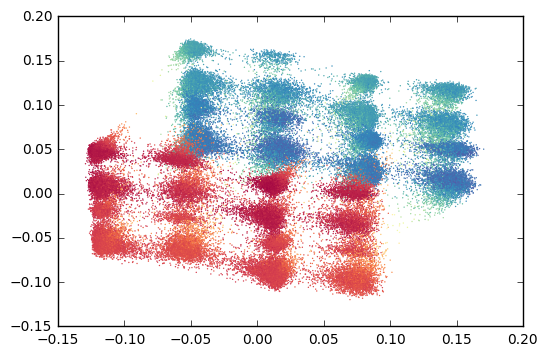

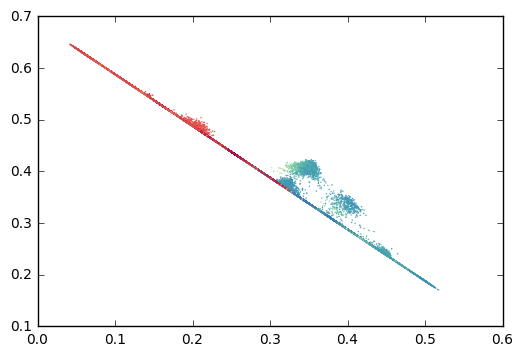

In [348]:
tica = pyemma.coordinates.tica(X, lag=lag)
X_tica = tica.get_output()
X_tica_ = np.vstack(X_tica)

c = X_tica_[:,0]

neural_proj = adaptive_vac.transform(X)
x = np.vstack(neural_proj)
plt.scatter(x[:,0], x[:,1], c=c, 
        linewidths=0, s = 1, cmap='Spectral')

plt.figure()
neural_proj = [adaptive_vac.neural_net_predict(adaptive_vac.params, x) for x in X]
x = np.vstack(neural_proj)
plt.scatter(x[:,0], x[:,1], c=c, 
        linewidths=0, s = 1, cmap='Spectral')

[  0.9835922    1.9462442    2.89214647   3.83472819   4.76158198
   5.67203027   6.56333142   7.41609607   8.25722447   9.08096938
   9.88628803  10.66725019  11.44489511  12.20293158  12.9319393
  13.64645086  14.09806172  14.52982961  14.94696238  15.34598042]
[ 604.45248635  262.72024624  179.80427763  169.11130279  131.64918471
  106.5891626    86.90141537   62.78580109   57.79980926   51.57447198
   46.1857001    40.44839668   39.76376294   36.09798392   31.63846437
   29.74808418   12.57965436   11.90664526   11.43705843   10.88436962]
[ 0.97440529  1.91922274]
[ 385.68415746  176.16938756]


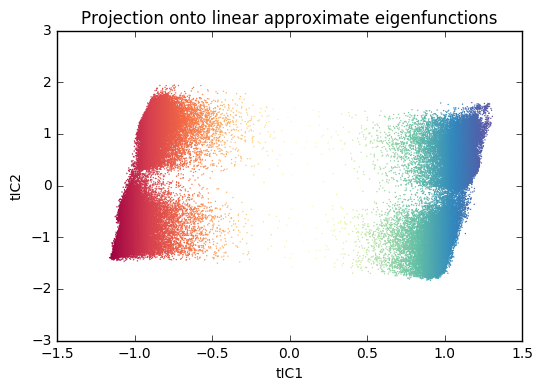

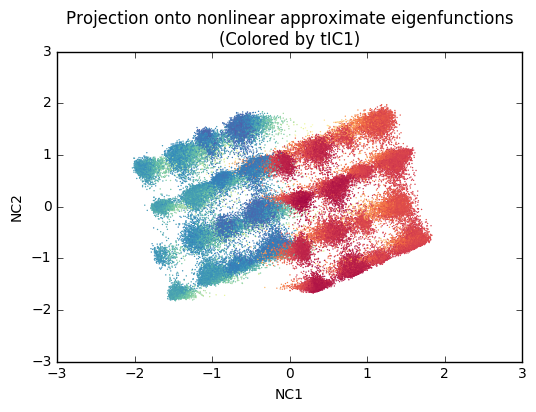

In [349]:
# tica of raw basis functions
tica = pyemma.coordinates.tica(X, lag=lag)
print(np.cumsum(tica.eigenvalues[tica.timescales>tica.lag]))
print(tica.timescales[tica.timescales>tica.lag])
X_tica = tica.get_output()
X_tica_ = np.vstack(X_tica)

c = X_tica_[:,0]
plt.title('Projection onto linear approximate eigenfunctions')
plt.scatter(X_tica_[:,0], X_tica_[:,1], c=c, 
        linewidths=0, s = 1, cmap='Spectral')
plt.xlabel('tIC1')
plt.ylabel('tIC2')

# tica of neural basis functions
neural_proj = adaptive_vac.transform(X)
neural_tica = pyemma.coordinates.tica(neural_proj, lag=lag, dim=2)
print(np.cumsum(neural_tica.eigenvalues[neural_tica.timescales>tica.lag]))
print(neural_tica.timescales)
X_tica = neural_tica.get_output()
X_tica_ = np.vstack(X_tica)

plt.figure()
plt.title('Projection onto nonlinear approximate eigenfunctions\n(Colored by tIC1)')
plt.scatter(X_tica_[:,0], X_tica_[:,1], c=c, 
        linewidths=0, s = 1, cmap='Spectral')
plt.xlabel('NC1')
plt.ylabel('NC2')

In [350]:
def build_msm(X_proj, lag):
    kmeans = pyemma.coordinates.cluster_kmeans(X_proj, k = 200, max_iter = 100)
    dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]
    msm = pyemma.msm.estimate_markov_model(dtrajs, lag = lag)
    print('\tMSM GMRQ-m: {0:.3f}'.format(np.sum(msm.eigenvalues()[:m])))
    print('\tFull trace of MSM transition matrix: {0:.3f}'.format(np.trace(msm.P)))
    print('\tSum of all MSM timescales: {0:.3f}'.format(np.sum(msm.timescales())))
    print('\tFirst few MSM timescales: {0}\n'.format(msm.timescales()[:5]))
    return msm

def compare_on_msms(X, optimized_params, lag, m):
    neural_proj = [neural_net_predict(optimized_params, x) for x in X]
    m = neural_proj[0].shape[1]
    print('Projected onto neural-approximate eigenfunctions (retained_dim={0})'.format(m))
    neural_msm = build_msm(neural_proj, lag)
    
    neural_tica = pyemma.coordinates.tica(neural_proj, lag)
    print('Projected onto tICA-rescaled neural-approximate eigenfunctions (retained_dim={0})'.format(min(neural_tica.ndim, m)))
    neural_tica_msm = build_msm([x[:,:m] for x in neural_tica.get_output()], lag)
    
    tica = pyemma.coordinates.tica(X, lag)
    print('Projected onto tICA-approximate eigenfunctions (retained_dim={0})'.format(min(tica.ndim, m)))
    tica_msm = build_msm([x[:,:m] for x in tica.get_output()], lag)
    
    return neural_msm, neural_tica_msm, tica_msm

def compare_timescales(timescales_list, m = 10):
    colors = ['blue', 'purple', 'green', 'red', 'orange']
    yscales = ['linear', 'log']
    
    xmax = 0
    
    
    for yscale in yscales:
        # timescales plot
        plt.figure()
        for i, (name, timescales) in enumerate(timescales_list):
            curve = timescales[:m]
            plt.plot(curve,'.', color=colors[i], label=name)
            plt.fill_between(range(len(curve)), curve, alpha=0.1, color=colors[i])
            
            xmax = max(xmax, np.argmax(timescales[:m] < lag))
        plt.hlines(lag, 0, m, linestyles='--', label='Lag')
            
        plt.legend(loc=(1,0))
        plt.xlabel('Process index')
        plt.ylabel('Implied timescale')
        plt.yscale(yscale)
        plt.xlim(0,xmax)
        
        # integrated kinetic content plot
        plt.figure()
        for i, (name, timescales) in enumerate(timescales_list):
            curve = np.cumsum(timescales)[:m]
            plt.plot(curve, color=colors[i], label=name)
            plt.fill_between(range(len(curve)), curve, alpha=0.1, color=colors[i])
        plt.legend(loc=(1,0))
        plt.xlabel('# of processes')
        plt.ylabel('Integrated kinetic content\n(Cumulative sum of implied timescales)')
        plt.yscale(yscale)
        plt.xlim(0,xmax)

In [351]:
neural_tica = pyemma.coordinates.tica(neural_proj, lag=lag, dim=2)

neural_msm = build_msm(neural_proj, lag = lag)

neural_tica_msm = build_msm(neural_tica.get_output(), lag = lag)

standard_tica = pyemma.coordinates.tica(X, lag=lag, dim=2)
tica_msm = build_msm([x[:,:m] for x in standard_tica.get_output()], lag = lag)

timescales_list = [('Neural adaptive MSM', neural_msm.timescales()),
                   ('Neural adaptive tICA-based MSM', neural_tica_msm.timescales()),
                   ('Standard tICA-based MSM', tica_msm.timescales()),
                   #('Standard tICA', standard_tica.timescales)
                  ]

30-10-16 11:13:55 pyemma.coordinates.clustering.kmeans.KmeansClustering[67] INFO     Cluster centers converged after 43 steps.
	MSM GMRQ-m: 1.981
	Full trace of MSM transition matrix: 32.606
	Sum of all MSM timescales: 3207.437
	First few MSM timescales: [ 512.10764035  276.57738308  225.39836958  170.76353227  148.12208141]

30-10-16 11:13:59 pyemma.coordinates.clustering.kmeans.KmeansClustering[68] INFO     Cluster centers converged after 8 steps.
	MSM GMRQ-m: 1.981
	Full trace of MSM transition matrix: 32.645
	Sum of all MSM timescales: 3229.828
	First few MSM timescales: [ 511.56762246  282.41920683  230.46721549  170.71355152  150.38924303]

30-10-16 11:14:06 pyemma.coordinates.clustering.kmeans.KmeansClustering[70] INFO     Cluster centers converged after 23 steps.
	MSM GMRQ-m: 1.990
	Full trace of MSM transition matrix: 22.393
	Sum of all MSM timescales: 2645.407
	First few MSM timescales: [ 1043.41594233   304.98381157   214.26027058    70.68816998    58.88144607]



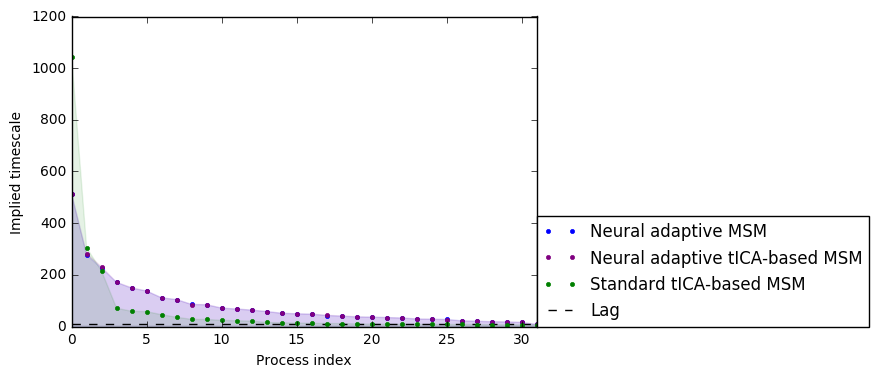

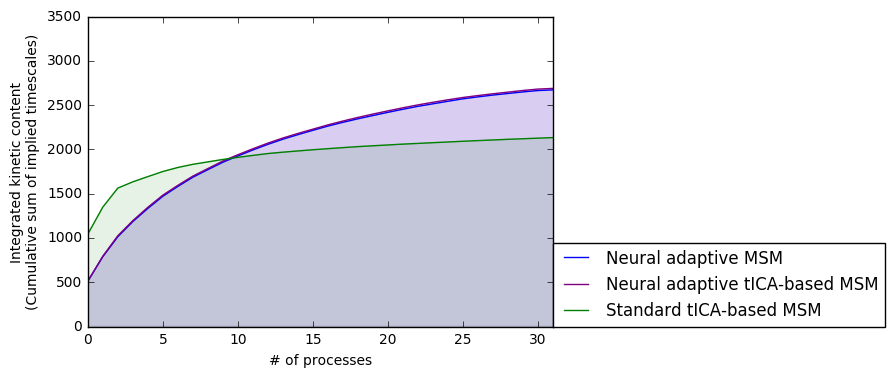

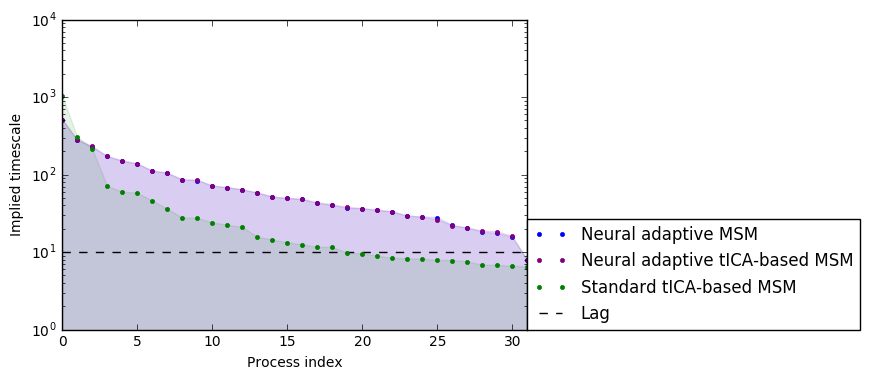

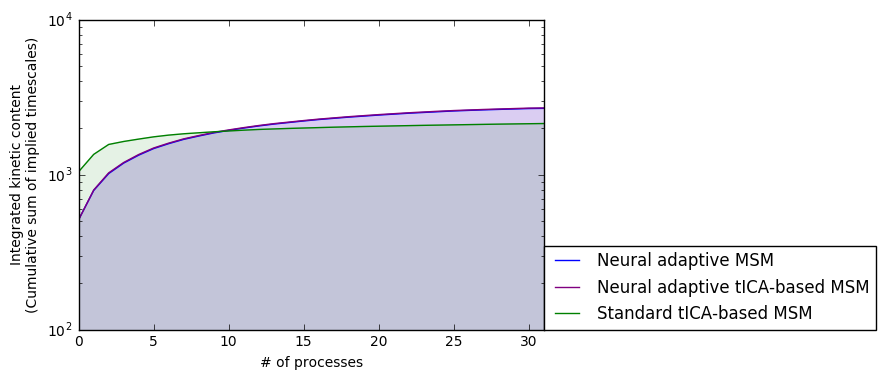

In [352]:
compare_timescales(timescales_list, m=200)

## 2. Toy example

Here we construct a "pathological" toy example where tICA won't help us much, because the dominant eigenfunctions have no correlation with any linear function of $X$.

Construction: Two nonconvex, isotropic clusters in 2D, with very slow transitions between the clusters, but instantaneous mixing within the clusters. Also, the cluster both have the same mean.

Difficulty: Because the relaxation process can't be expressed as a linear combination of the input features, tICA will be unable to estimate a 

Regardless, this is an easy problem for MSMs!

In [339]:
# sample from this process
npr.seed(0)
eps = 0.001
P = np.eye(2)*(1 - eps)
P[0,1] = eps
P[1,0] = eps

msm = pyemma.msm.markov_model(P)
dtraj = msm.simulate(100000)

def normalize(x): return x / np.linalg.norm(x)

X = [np.array([(1+0.05*np.random.randn())*(d+1)*normalize(np.random.randn(2)) for d in dtraj])]

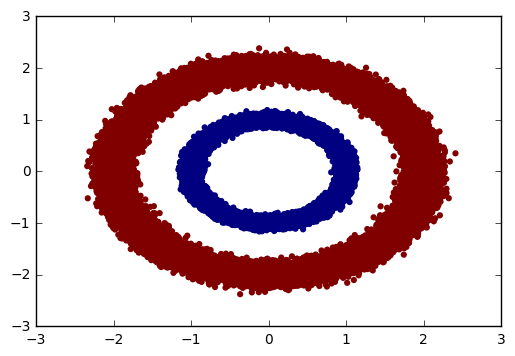

In [11]:
plt.scatter(X[0][:,0], X[0][:,1], linewidths=0, c=dtraj)

In [12]:
%%time
m = 2
lag = 1
adaptive_vac = NeuralApproximatePropagator(lag = lag, m = m, minibatch_size=50)
adaptive_vac.fit(X)

     Epoch     |       Rayleigh Quotient
              0|      0.958570079282
              1|       1.92534704433
              2|       1.96833614876
              3|       1.96657714816
              4|        1.9735769776
              5|        1.9686784952
              6|       1.97448872026
              7|       1.96426061017
              8|       1.98243346826
              9|       1.98425148304
CPU times: user 36.5 s, sys: 13.8 s, total: 50.3 s
Wall time: 36.6 s


[ 68.52779485   0.16114651]
[ 0.18631622  0.14102153]


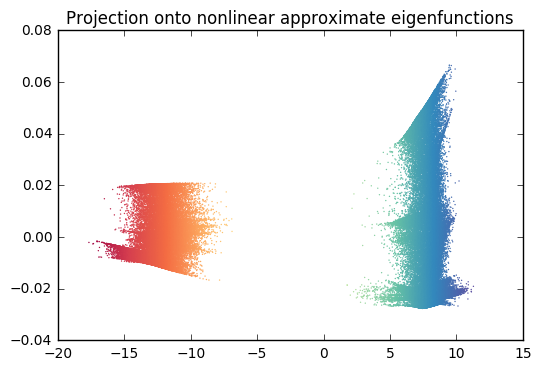

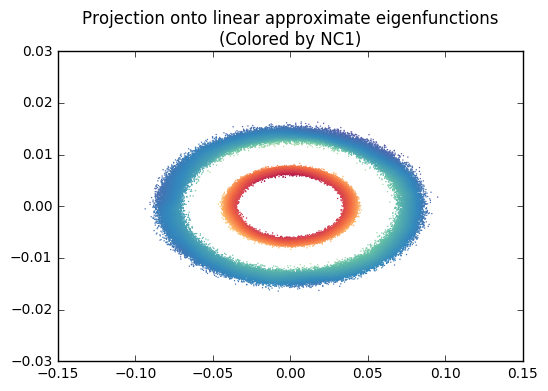

In [13]:
# tica of neural basis functions
plt.figure()
neural_proj = adaptive_vac.predict(X)
neural_tica = pyemma.coordinates.tica(neural_proj, lag=lag, dim=2)
print(neural_tica.timescales)
X_tica = neural_tica.get_output()
X_tica_ = np.vstack(X_tica) * 10
# multiplied by 10 because matplotlib doesn't like to plot axes with very small amounts of variation
c = X_tica_[:,0]

plt.title('Projection onto nonlinear approximate eigenfunctions')
plt.scatter(X_tica_[:,0], X_tica_[:,1], c=c, 
        linewidths=0, s = 1, cmap='Spectral')

# tica of raw basis functions
plt.figure()
tica = pyemma.coordinates.tica(X, lag=lag, dim=2)
print(tica.timescales)
X_tica = tica.get_output()
X_tica_ = np.vstack(X_tica) * 10

plt.title('Projection onto linear approximate eigenfunctions\n(Colored by NC1)')
plt.scatter(X_tica_[:,0], X_tica_[:,1], c=c, 
        linewidths=0, s = 1, cmap='Spectral')

## 3. Toy example revisited

Here we slightly modify the previous toy example, by shiting the mean of one of the clusters slightly in the x direction.

This will allow tICA to pick up a slow relaxation timescale in one direction.

This would be an absolute worst-case scenario for the pipeline approach, since the metric learned by kinetic-maps tICA or commute-maps tICA would "squash" (or discard) the remaining direction.
- In the "kinetic maps" approach, we might by default retain the components required to explain 95% of the "kinetic variance." In this case, tIC1 explains ~99.7% of the kinetic variance, so we would discard one of our axes.
- In the "commute maps" approach, we might by default discard any components whose implied timescale is less than the estimation lag time. In this case, both implied timescales are lower than the lag time.

In [14]:
# sample from this process
npr.seed(0)
eps = 0.001
P = np.eye(2)*(1 - eps)
P[0,1] = eps
P[1,0] = eps

msm = pyemma.msm.markov_model(P)
dtraj = msm.simulate(100000)

def normalize(x): return x / np.linalg.norm(x)

X = np.array([(1+0.05*np.random.randn())*(d+1)*normalize(np.random.randn(2))+(d==1)*np.array((0.4,0)) for d in dtraj])

## also corrupt 1% of observations?
#for i in range(int(len(dtraj)*0.01)):
#    X[npr.randint(len(X))] = npr.randn(2)
## nahhh...

X = [X]

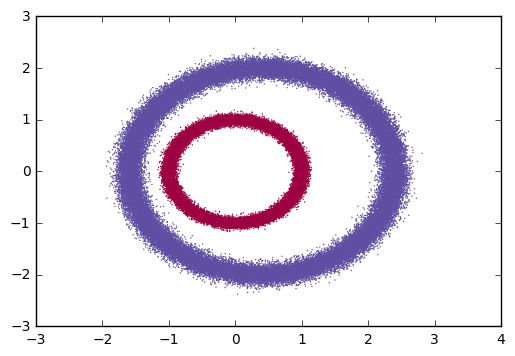

In [15]:
plt.scatter(X[0][:,0], X[0][:,1], linewidths=0, c=dtraj, s=1, cmap='Spectral')

In [16]:
%%time
m = 2
lag = 1
adaptive_vac = NeuralApproximatePropagator(lag = lag, m = m, minibatch_size=100)
adaptive_vac.fit(X)

     Epoch     |       Rayleigh Quotient
              0|      0.455502829887
              1|       1.92577017661
              2|        1.9519895471
              3|       1.93955654749
              4|       1.96082978193
              5|       1.96349904151
              6|        1.9696307277
              7|       1.95624164099
              8|       1.96937012733
              9|       1.97457869052
CPU times: user 33.9 s, sys: 12.6 s, total: 46.4 s
Wall time: 33.6 s


In [17]:
adaptive_vac.predict([np.ones((1,2))])

[array([[-0.00921237,  0.29967818]])]

[ 40.39180198   0.15962894]
[ 0.2608466   0.14679886]


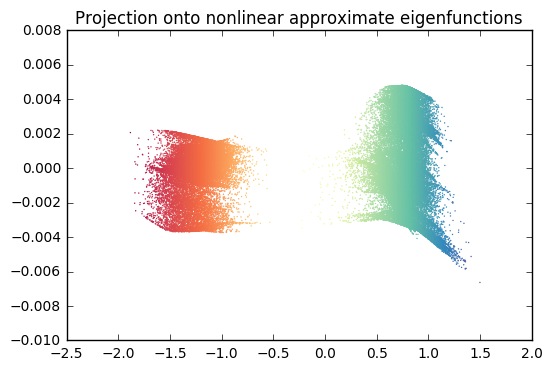

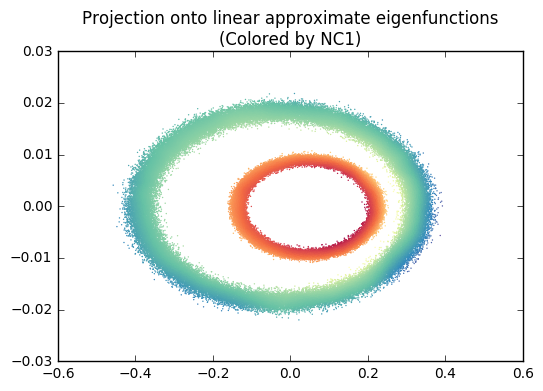

In [18]:
# tica of neural basis functions
plt.figure()
neural_proj = adaptive_vac.predict(X)
neural_tica = pyemma.coordinates.tica(neural_proj, lag=lag, dim=2)
print(neural_tica.timescales)
X_tica = neural_tica.get_output()
X_tica_ = np.vstack(X_tica)
c = X_tica_[:,0]

plt.title('Projection onto nonlinear approximate eigenfunctions')
plt.scatter(X_tica_[:,0], X_tica_[:,1], c=c, 
        linewidths=0, s = 1, cmap='Spectral')

# tica of raw basis functions
plt.figure()
tica = pyemma.coordinates.tica(X, lag=lag, dim=2)
print(tica.timescales)
X_tica = tica.get_output()
X_tica_ = np.vstack(X_tica) * 10

plt.title('Projection onto linear approximate eigenfunctions\n(Colored by NC1)')
plt.scatter(X_tica_[:,0], X_tica_[:,1], c=c, 
        linewidths=0, s = 1, cmap='Spectral')

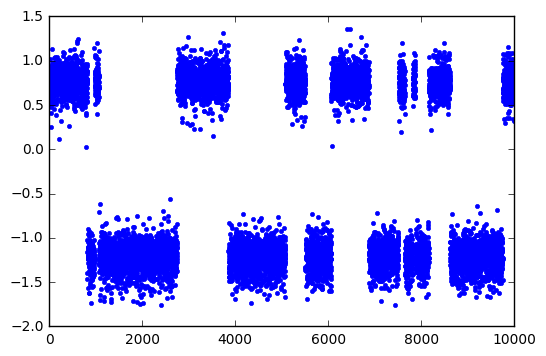

In [19]:
plt.plot(neural_tica.get_output()[0][:10000,0],'.')

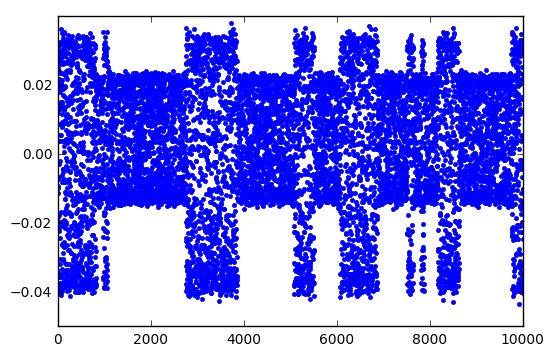

In [20]:
plt.plot(tica.get_output()[0][:10000,0],'.')

In [21]:
tica.cumvar

array([ 0.99741835,  1.        ])

In [22]:
tica.timescales

array([ 0.2608466 ,  0.14679886])

m = 2
hidden_layer_dims = [256, 64]
nonlinearity=lambda x:np.maximum(0, x)


# ideas:
- For now, hard-code the model as a 2D linear projection, with full covariance mixture components
- Partition of unity basis functions: could then be easier to then cluster:
    - A problem with the MLP eigenfunction approximation is that there's not an easy way to immediately get a discrete-state MSM out of it -- you still end up having to do tICA.
- Initialize projection at tICA solution?
- Toy problem that illustrates why having the 2D projection correspond to linear-approximate eigenfunctions isn't always the best idea, when you're eventually going to be defining your basis functions in terms of clusters in the projection.
    - 8 clusters on corners of a cube: independent slow processes along x, y, z axis, with slightly different timescales. If you project just onto the x and y axis, you can't resolve the z-axis slow process.
- Is there a way to "regularize" at the last step, so that the model only uses as many clusters are necessary?

In [7]:
import numpy as np
n_states = 10
P = np.eye(n_states, n_states)

In [4]:
# 

def metastable_matrix(n_states, eps=0.01): return np.eye(n_states, n_states)*(1-eps) + eps
    
def cube_example():
    
    # 3 separate 2x2 markov matrices for transitions in each axis
    pass

In [ ]:
class LowRankGaussianModel():
    def __init__(self, input_dim, latent_dim, n_centers):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
    
    def initialize_params():
        
    def unpack_params():
        

In [33]:
class LinearModel():
    '''f_theta(x) = (x + b)A
        theta = {A, b}
        
        x \in R^D
        b \in R^D
        A \in R^{D x d}
    '''
    def __init__(self, input_dim, latent_dim):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.initialize()
    
    def initialize(self):
        self.A = np.random.randn(self.input_dim, self.latent_dim)
        self.b = np.random.randn(self.input_dim)
        self.num_params = np.prod(self.A.shape) + self.input_dim
    
    def parse_params(self, params):
        d = np.prod(self.A.shape)
        A = params[:d].reshape(self.A.shape)
        b = params[d:]
        return A, b
    
    @property
    def params(self):
        return np.concatenate([self.A.flatten(), self.b])
    
    def predict(self, params, x):
        A, b = self.parse_params(params)
        return np.dot(x+b, A)

In [86]:
class PartitionOfUnityModel():
    '''
    '''
    
    def __init__(self, dimension, n_centers):
        self.dimension = dimension
        self.n_centers = n_centers
        self.initialize()
    
    def initialize(self):
        self.means = np.random.randn(self.n_centers, self.dimension)
        self.covariances = np.vstack([np.eye(self.dimension, self.dimension)] * self.n_centers)
        self.num_params = np.prod(self.means.shape) + np.prod(self.covariances.shape)
    
    def parse_params(self, params):
        d = np.prod(self.means.shape)
        means, covariances = params[:d].reshape(self.means.shape), params[d:].reshape(self.covariances.shape)
        return means, covariances
    
    @property
    def params(self):
        return np.concatenate([self.means.flatten(), self.covariances.flatten()])
    
    def predict(self, params, x):
        means, covariances = self.parse_params(params)
        
        log_densities = np.array([mvn.logpdf(x, means[i], covariances[i]) for i in range(len(means))])
        print(log_densities.shape)
        # return np.exp(log_densities) # if we don't care about these being membership functions
        
        Z = logsumexp(log_densities)
        return np.exp(log_densities - Z)

In [87]:
x = {'x':1, 'y':2}
x.values()

[2, 1]

In [123]:
class PartitionOfUnityModel():
    '''
    '''
    
    def __init__(self, dimension, n_components, init_scale=0.1):
        self.dimension = dimension
        self.n_components = n_components
        self.initialize(init_scale)
    
    def initialize(self, init_scale):
        self.params = {
            'means':           np.random.randn(self.n_components, self.dimension) * init_scale,
            'lower triangles': np.zeros((self.n_components, self.dimension, self.dimension)) + np.eye(self.dimension)}
        
        self.num_params = sum([np.prod(param.shape) for param in self.params.values()])
    
    def parse_params(self, params):
        return params['means'], params['lower triangles']
    
    @property
    def params(self):
        return np.concatenate([self.params[key].flatten() for key in ['means', 'lower triangles']])
    
    def predict(self, params, x):
        means, cov_sqrts = self.parse_params(params)
        
        log_densities = np.array([mvn.logpdf(x, means[i], np.dot(cov_sqrts[i].T, cov_sqrts[i])) for i in range(len(means))])
        # return np.exp(log_densities).T # if we don't care about these being membership functions
        
        Z = logsumexp(log_densities, axis=0)
        return np.exp(log_densities - Z).T

In [173]:
class IsotropicGaussianModel():
    def __init__(self, dimension, n_components, init_scale=0.1):
        self.dimension = dimension
        self.n_components = n_components
        self.initialize(init_scale)
    
    def initialize(self, init_scale):
        self.means = np.random.randn(self.n_components, self.dimension) * init_scale
        self.params = self.means
        self.num_params = np.prod(means.shape)
    
    def predict(self, params, x):
        return np.exp(- np.array([np.sum((x - mean)**2,1) for mean in params])).T

In [163]:
class IsotropicPartitionOfUnityModel():
    ''' special case of PartitionOfUnityModel, where the covariances are all identity matrices
    
    PartitionOfUnityModel was unusably slow -- I suspect the culprit is in the mvn.logpdf function?
    
    In any case, we might want to compose this with a MLP, so that we try to find a low-dimensional embedding where
    the metastable basins are well approximated by isotropic Gaussians.
    
    I guess I could also accomplish this by just having an RBF layer at the end
    '''
    def __init__(self, dimension, n_components, init_scale=0.1):
        self.dimension = dimension
        self.n_components = n_components
        self.initialize(init_scale)
    
    def initialize(self, init_scale):
        self.params = {
            'means':           np.random.randn(self.n_components, self.dimension) * init_scale}
        
        self.num_params = sum([np.prod(param.shape) for param in self.params.values()])
    
    def parse_params(self, params):
        return params['means']
    
    @property
    def params(self):
        return self.params['means']
    
    def predict(self, params, x):
        means = self.parse_params(params)
        
        log_densities = - np.array([np.sum((x - mean)**2,1) for mean in means])
        
        # return np.exp(log_densities).T # if we don't care about these being membership functions
        
        Z = logsumexp(log_densities, axis=0)
        print(Z.shape)
        
        return np.exp(log_densities - Z).T

In [ ]:
# now we can compose models

class Sequential():
    ''' each model needs to have a `.num_params` attribute, a `.params` property, and a `.predict(params, x)` method '''
    def __init__(self, models):
        self.models = models
        
    def parse_params(self, params):
        param_list = []
        t = 0
        for i in range(len(models)):
            param_list.append(params[t : t+models[i].num_params])
            t += models[i].num_params
        return param_list
    
    @property
    def params(self):
        return np.concatenate([model.params for model in self.models])
    
    def predict(self, params, x):
        param_list = self.parse_params(params)
        for i in range(len(self.models)): x = model[i].predict(param_list[i], x)
        return x

In [159]:
x = np.ones((1000,2))
means = np.ones((10,2))
log_densities = - np.array([np.sum((x - mean)**2,1) for mean in means])
log_densities.shape # should be of size 1000 by 10?

(10, 1000)

In [ ]:
np.exp(-)

In [124]:
x = np.ones((100,2))
x.sum(0).shape

(2,)

In [125]:
logsumexp(x,axis=-1).shape

(100,)

In [126]:
pou = PartitionOfUnityModel(2, 10)
x = np.random.randn(1000,2)
pou.predict(pou.params, x).shape

(1000, 10)

In [127]:
x = np.random.randn(1000,38)
model.predict(model.params, x).shape

(1000, 2)

In [146]:
class ApproximatePropagator():
    '''Accepts an arbitrary differentiable model.
    The model needs to have a method `model.predict(params, X)`
    '''
    
    def __init__(self,
                 model,
                 lag = 10,
                 minibatch_size = 5000,
                ):
        '''
        model : 
        lag : lag-time for estimation
        minibatch_size : number of time-lagged observation pairs per minibatch
        
        special case:
        - should recover tICA if model is a linear transformation
        '''
        self.lag = lag
        self.minibatch_size = minibatch_size
        self.model = model
        
    def rayleigh_quotient(self, X_0_minus_tau, X_tau):
        '''trace of P Q^{-1}
        where:
        - $P_{ij} = \mathbb{E}_{x \sim \pi(x)}[f_i(x) \cdot (\mathcal{P} \circ f_j(x))]$ and
        - $Q_{ij} = \mathbb{E}_{x \sim \pi(x)}[f_i(x) \cdot f_j(x)]$.'''
        P = np.dot(X_0_minus_tau.T, X_tau) / len(X_tau)
        Q = np.dot(X_0_minus_tau.T, X_0_minus_tau) / len(X_0_minus_tau)
        return np.trace(np.dot(P, np.linalg.inv(Q)))

    def fit(self, X, num_iters = 1000, step_size = 0.001, report_interval = 100):
        stacked_X = np.vstack([x[:-self.lag] for x in X])
        stacked_Y = np.vstack([x[self.lag:] for x in X])
        dim = X[0].shape[1]

        def objective(params, iter):
            ''' minibatch estimator of -log(rayleigh quotient) '''
            inds = np.arange(len(stacked_X))
            np.random.shuffle(inds)
            inds = inds[:self.minibatch_size]

            x = self.model.predict(params, stacked_X[inds])
            y = self.model.predict(params, stacked_Y[inds])
            
            return - np.log(self.rayleigh_quotient(x, y))

        # Get gradient of objective using autograd!
        objective_grad = grad(objective)

        print("     Epoch     |       Rayleigh Quotient")
        def save_params_and_print_perf(params, iter, gradient):
            self.params = params
            if iter % report_interval == 0:
                x = self.model.predict(params, stacked_X)
                y = self.model.predict(params, stacked_Y)
                rq = self.rayleigh_quotient(x, y)
                print("{:15}|{:20}".format(iter//report_interval, rq))
                
        init_params = self.model.params
        self.params = adam(objective_grad, init_params, step_size=step_size,
                                num_iters=num_iters, callback=save_params_and_print_perf)
        return self
    
    def transform(self, X):
        return [self.model.predict(self.params, x) for x in X]

In [147]:
model = LinearModel(input_dim=X[0].shape[1], latent_dim=2)

In [148]:
adaptive_vac = ApproximatePropagator(model, lag=lag)

In [53]:
adaptive_vac.fit(X, num_iters=5000)

     Epoch     |       Rayleigh Quotient
              0|       1.46326490476
              1|        1.5158961964
              2|       1.55266722162
              3|       1.58302551038
              4|       1.61052847389
              5|       1.63755500798
              6|        1.6660951383
              7|       1.69885782921
              8|       1.73569817552
              9|       1.77229562913
             10|       1.80457722688
             11|       1.83429957792
             12|       1.86158777702
             13|       1.88299930284
             14|        1.8963375449
             15|       1.90334165308
             16|       1.90677256636
             17|       1.90857542004
             18|       1.90945495663
             19|       1.90998818073
             20|       1.91033166146
             21|       1.91062144002
             22|        1.9108412509
             23|       1.91102156924
             24|       1.91121494997
             25|       1.911371631

<__main__.ApproximatePropagator instance at 0x119790290>

In [56]:
X_nc = adaptive_vac.transform(X)

In [61]:
tica = pyemma.coordinates.tica(X, lag=lag)
X_tica = tica.transform(X)
np.sum(tica.eigenvalues[:2])

1.7147825459061001

In [62]:
tica_tica = pyemma.coordinates.tica(X_tica, lag=lag)
np.sum(tica_tica.eigenvalues[:2])

1.7147825459547095

In [63]:
tica_nc = pyemma.coordinates.tica(X_nc, lag=lag)
np.sum(tica_nc.eigenvalues[:2])

1.4317963642734997

In [ ]:
# hmm, so that indicates there's a bit of a problem! the objective I'm optimizing isn't quite correct...

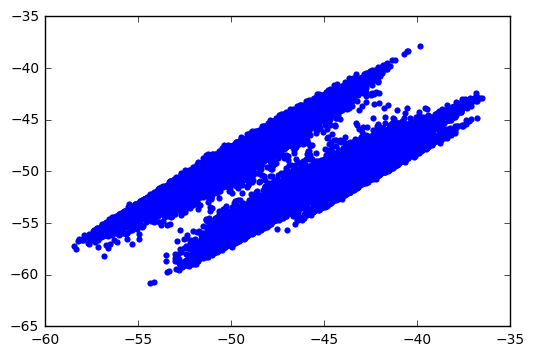

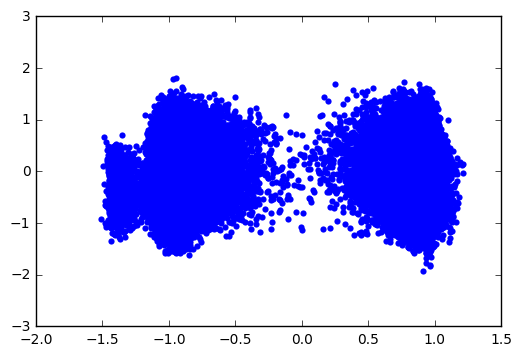

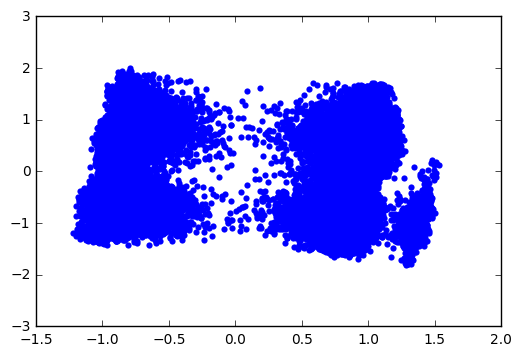

In [68]:
x = np.vstack(X_nc)
plt.scatter(x[:,0], x[:,1], linewidths=0)

plt.figure()
x = np.vstack(tica_nc.get_output())
plt.scatter(x[:,0], x[:,1], linewidths=0)

plt.figure()
plt.figure()
x = np.vstack(X_tica)
plt.scatter(x[:,0], x[:,1], linewidths=0)

In [67]:
adaptive_vac.model.b

array([ 0.8649771 ,  0.56664425,  0.78096635,  1.07795859, -0.51324123,
       -0.07102671,  0.93464268, -1.77337753, -0.0054848 , -0.45168219,
        1.27882273, -1.2606819 , -0.18512056, -0.53618326, -1.46680608,
       -1.14007503,  1.48258567, -0.49630858,  0.06516525, -0.60265814,
        0.70373658,  0.13073348,  2.58464626,  1.20302525,  1.01327349,
        2.21251584, -0.57040774, -0.62423023,  0.99103175,  1.44528623,
        0.28236786,  1.76959325,  0.12225515, -1.59443832,  0.32713004,
        0.02251335, -0.13540189,  0.91399953])

In [149]:
# here, let's just say we have a projection we can use
tica = pyemma.coordinates.tica(X, lag=lag, dim=2)
X_tica = tica.transform(X)

In [152]:
%%prun
n_clusters = 10
d = X_tica[0].shape[1]
pou = PartitionOfUnityModel(d, n_clusters)
adaptive_vac = ApproximatePropagator(pou, lag=lag)
adaptive_vac.fit(X_tica, num_iters=10, report_interval = 1, step_size=0.1)

     Epoch     |       Rayleigh Quotient
              0|       5.97901337108
              1|       6.01056494203
              2|       6.00124142022
              3|       5.92125045298
              4|       5.87171681573
              5|       5.79230772266
              6|       5.69291882416
              7|       5.43188325167
              8|       5.13620792833
              9|       4.90633515334
 

In [166]:
%%time
n_clusters = 4
d = X_tica[0].shape[1]
pou = IsotropicPartitionOfUnityModel(d, n_clusters)
adaptive_vac = ApproximatePropagator(pou, lag=lag)
adaptive_vac.fit(X_tica, num_iters=100, report_interval = 1, step_size=0.1)

     Epoch     |       Rayleigh Quotient
              0|       3.35938936415
              1|       3.28565636287
              2|       3.28570348128
              3|       3.35661318914
              4|       3.40172044177
              5|       3.41895730098
              6|       3.42611411221
              7|       3.42961585141
              8|       3.43151621289
              9|       3.43253347557
             10|       3.43328244932
             11|       3.43388694307
             12|       3.43446617391
             13|       3.43499954202
             14|       3.43545731896
             15|       3.43589314899
             16|       3.43628951547
             17|       3.43668381427
             18|       3.43706843212
             19|       3.43745033989
             20|       3.43781520026
             21|       3.43814728364
             22|       3.43845580699
             23|       3.43874193893
             24|       3.43902097325
             25|       3.439290816

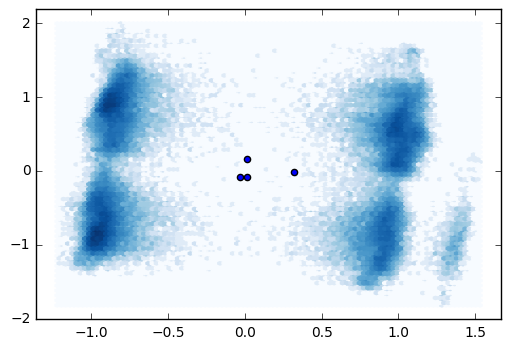

In [169]:
x = np.vstack(X_tica)
plt.hexbin(x[:,0], x[:,1], bins='log', cmap='Blues')

centers = adaptive_vac.model.params['means']
plt.scatter(centers[:,0], centers[:,1])

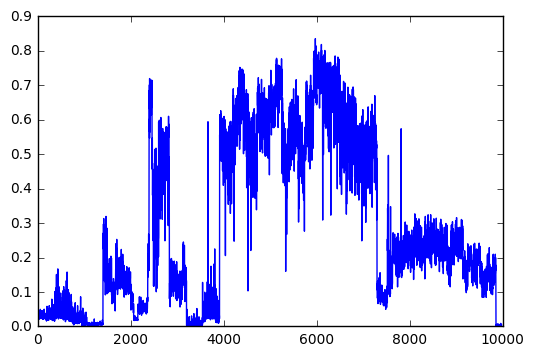

In [171]:
X_nc = adaptive_vac.transform(X_tica)
plt.plot(X_nc[0][:,0])

In [ ]:
# nope, it's just really slow, even when I use a different function for the gaussian density...
# is it because of weird dependency structure introduced by the logsumexp step? I don't understand
# why this is so much more expensive than MLP updates...

# also, looks like the partition of unity model may be harder to train, since it only needs each center
# to be slightly closer to the metastable basing than the others?

# should revisit later

# we can always get a crisp partitioning later, by taking the argmax...

In [178]:
%%time
n_clusters = 4
d = X_tica[0].shape[1]
model = IsotropicGaussianModel(d, n_clusters)
adaptive_vac = ApproximatePropagator(model, lag=lag)
adaptive_vac.fit(X_tica, num_iters=100, report_interval = 1, step_size=1.0)

     Epoch     |       Rayleigh Quotient
              0|       2.78031152779
              1|       2.88972373079
              2|       2.84694068351
              3|       2.88137964622
              4|       2.79166847494
              5|       2.68935328178
              6|       2.47992010517
              7|       2.27258700931
              8|        2.1488130936


KeyboardInterrupt: 

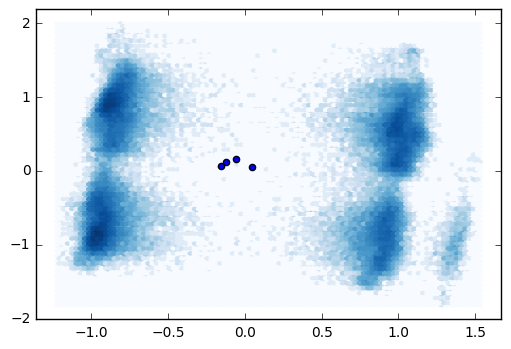

In [177]:
x = np.vstack(X_tica)
plt.hexbin(x[:,0], x[:,1], bins='log', cmap='Blues')

centers = adaptive_vac.model.means
plt.scatter(centers[:,0], centers[:,1])